In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Run Segment Anything Model 2 on a live video stream


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from IPython import display
import json
import time

In [2]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### Loading the SAM 2 camera predictor


In [3]:
from sam2.build_sam import build_sam2_camera_predictor

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "configs/sam2/sam2_hiera_l.yaml"

predictor = build_sam2_camera_predictor(model_cfg, sam2_checkpoint)

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_bbox(bbox, ax, marker_size=200):
    tl, br = bbox[0], bbox[1]
    w, h = (br - tl)[0], (br - tl)[1]
    x, y = tl[0], tl[1]
    print(x, y, w, h)
    ax.add_patch(plt.Rectangle((x, y), w, h, fill=None, edgecolor="blue", linewidth=2))

#### Select an video stream (video or camera)


In [5]:
# cap = cv2.VideoCapture("videos/aquarium/aquarium.mp4")
# ret, frame = cap.read()
# width, height = frame.shape[:2][::-1]

# frame = Image.open("videos/prompts/0001.jpg")

# scan all the JPEG frame names in this directory
video_dir = "videos/prompts"
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

#### Step 1: Add a first click on the first frame


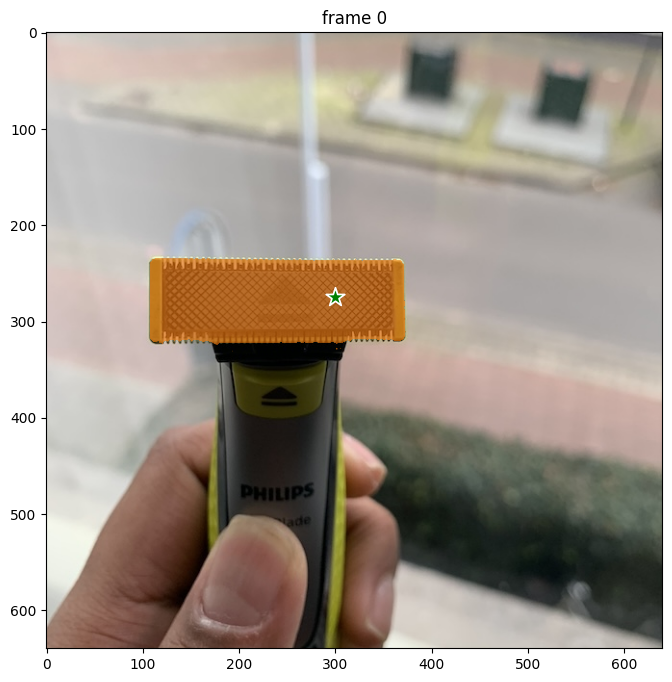

In [6]:
frame = Image.open(os.path.join(video_dir, frame_names[0]))
predictor.load_first_frame(frame)
if_init = True

using_point = True # if True, we use point prompt
using_box = False # if True, we use point prompt
using_mask= False  # if True, we use mask prompt

ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = (
    1  # give a unique id to each object we interact with (it can be any integers)
)
# Let's add a positive click at (x, y) = (210, 350) to get started

# read the point info from json file
json_path = frame_names[0].replace(".jpg", ".json")
with open(os.path.join(video_dir,json_path), "r") as f:
    json_data = json.load(f)
    points = np.array(json_data["points"], dtype=np.float32)
    labels = np.array(json_data["labels"], dtype=np.int32)

# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(frame)


if using_point:
    _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
    )
    show_points(points, labels, plt.gca())

# elif using_box:
#     _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
#         frame_idx=ann_frame_idx, obj_id=ann_obj_id, bbox=bbox
#     )
#     show_bbox(bbox, plt.gca())

# elif using_mask:
#     mask_img_path="masks/aquarium/aquarium_mask.png"
#     mask = cv2.imread(mask_img_path, cv2.IMREAD_GRAYSCALE)
#     mask = mask / 255

#     _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
#         frame_idx=ann_frame_idx, obj_id=ann_obj_id, mask=mask
#     )
    


show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

#### Step 2: track


shape  4  frame index  3


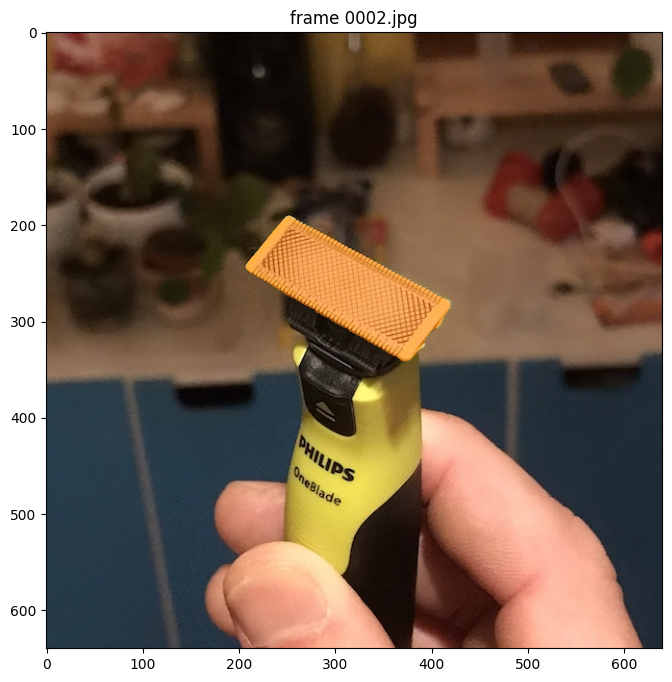

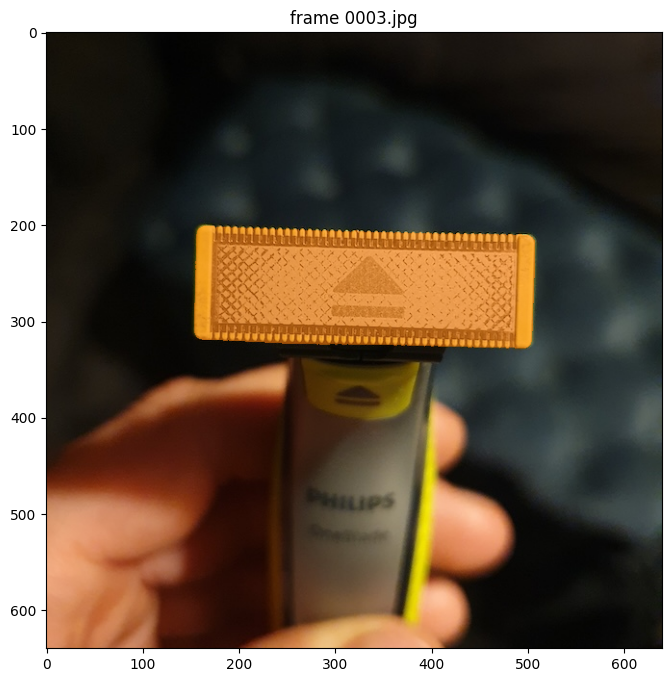

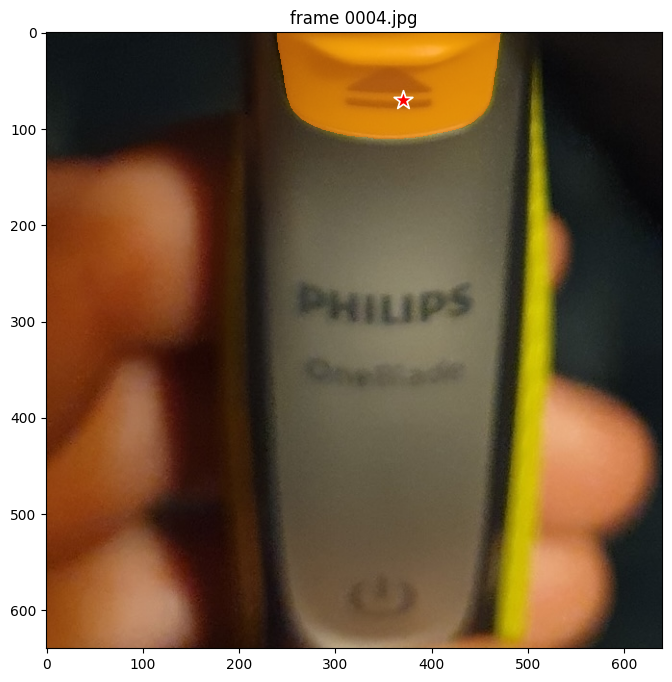

In [7]:
for file in frame_names[1:]:
    if not file.endswith(".jpg"):
        continue
    frame = Image.open(os.path.join(video_dir, file))
    out_obj_ids, out_mask_logits = predictor.track(frame)
    predictor.add_conditioning_frame(frame)
                
    ## ! add new bbox
    json_path = file.replace(".jpg", ".json")
    json_file_path = os.path.join(video_dir, json_path)

    plt.figure(figsize=(12, 8))
    plt.title(f"frame {file}")
    
    # Check if the JSON file exists before trying to open it
    if os.path.exists(json_file_path):
        with open(json_file_path, "r") as f:
            json_data = json.load(f)
            points = np.array(json_data["points"], dtype=np.float32)
            labels = np.array(json_data["labels"], dtype=np.int32)
            
        ann_obj_id = 1
        predictor.add_new_prompt_during_track(
            point=points,
            labels=labels,
            obj_id=ann_obj_id, 
            if_new_target=False,
            clear_old_points=False
        )
        show_points(points, labels, plt.gca())
    else:
        print(f"Warning: JSON file not found for {file}, skipping prompt addition.")

    plt.imshow(frame)
    show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [12]:
from PIL import Image

image_size = 640

def resize_and_crop(image: Image.Image) -> Image.Image:
    # Step 1: Resize image to width = 640, keeping aspect ratio
    w_percent = image_size / float(image.width)
    new_height = int(float(image.height) * w_percent)
    resized = image.resize((image_size, new_height), Image.LANCZOS)

    # Step 2: Crop vertically to height = 640, centered
    if new_height > image_size:
        top = (new_height - image_size) // 2
        bottom = top + image_size
        cropped = resized.crop((0, top, image_size, bottom))
    else:
        # If resized height is less than 640, pad instead (optional)
        cropped = resized

    return cropped


In [27]:
# scan all the JPEG frame names in this directory
video_dir = "videos/random_images"
# Use os.walk to find all frame files in the directory and subdirectories
frame_names = []
for root, dirs, files in os.walk(video_dir):
    for file in files:
        if os.path.splitext(file)[-1].lower() in [".jpg", ".jpeg"]:
            # Store the relative path from video_dir
            rel_path = os.path.relpath(os.path.join(root, file), video_dir)
            frame_names.append(rel_path)

# Sort frames by numeric part of the filename if possible
try:
    frame_names.sort(key=lambda p: int(os.path.splitext(os.path.basename(p))[0]))
except ValueError:
    # Fall back to regular sorting if conversion to int fails
    frame_names.sort()

In [28]:
frame_names

['352-640x640.jpg',
 '448-640x640.jpg',
 '473-200x200.jpg',
 '868-640x640.jpg',
 '987-640x640.jpg']

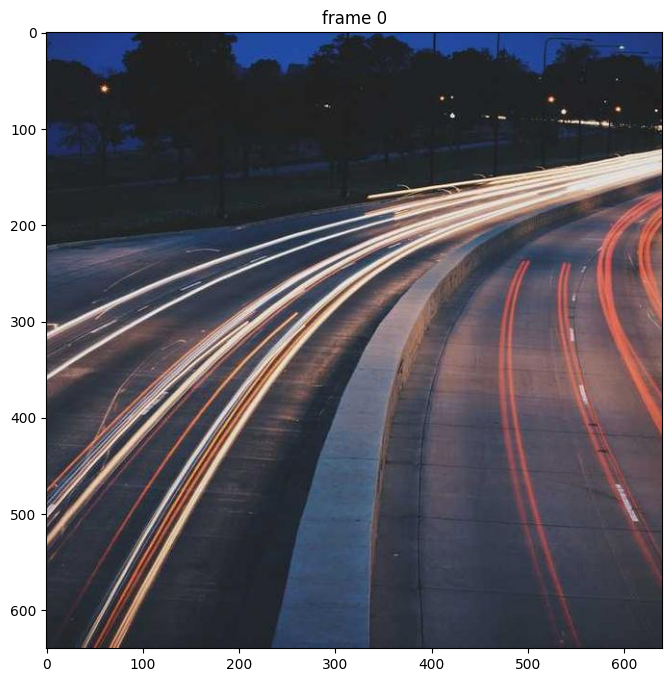

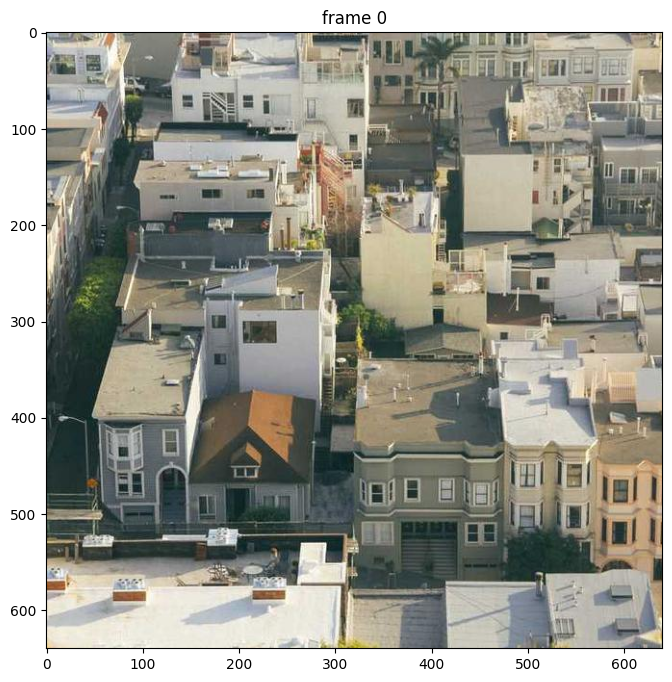

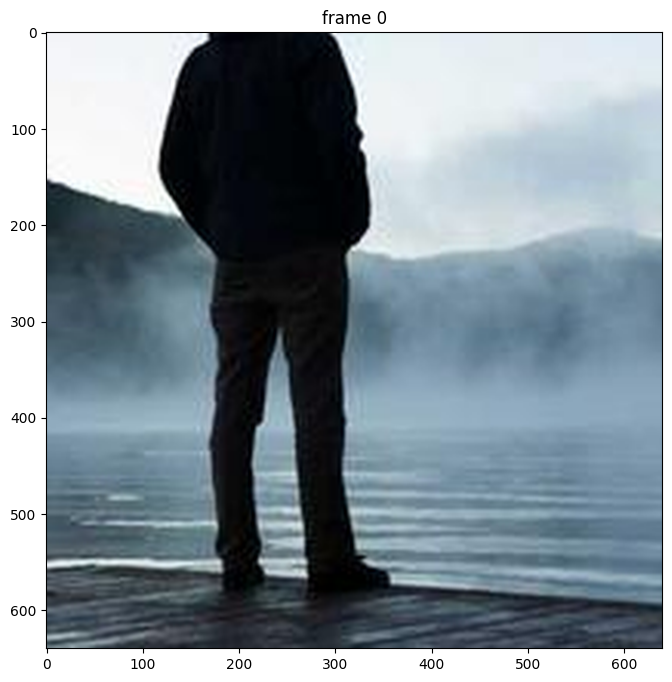

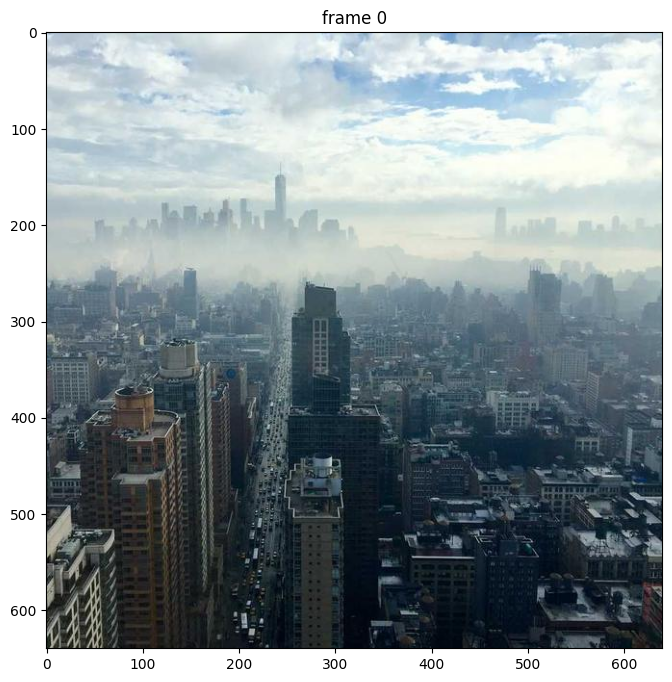

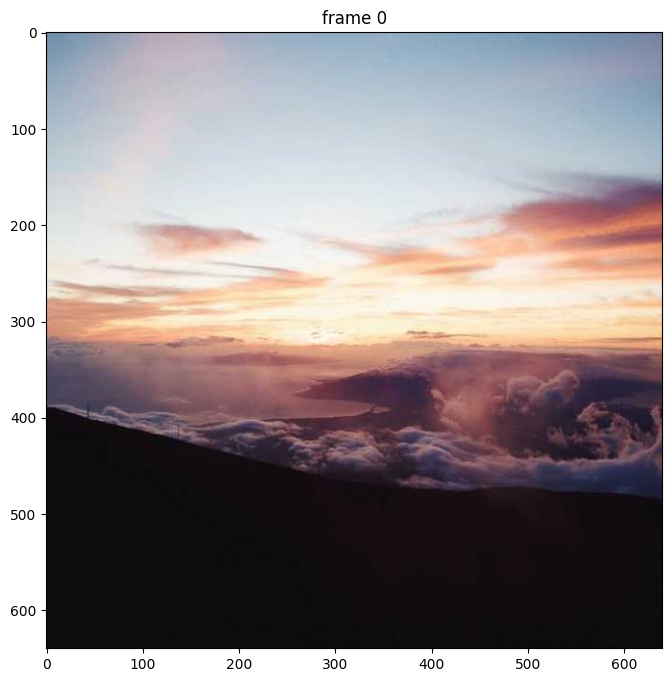

In [29]:
for file in frame_names:
    if not file.endswith(".jpg"):
        continue
    t1 = time.time()
    frame = Image.open(os.path.join(video_dir, file))
    frame = resize_and_crop(frame)
    out_obj_ids, out_mask_logits = predictor.track(frame)
    # print("time: ", time.time()-t1)
    plt.figure(figsize=(12, 8))
    plt.title(f"frame {ann_frame_idx}")
    plt.imshow(frame)
    show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

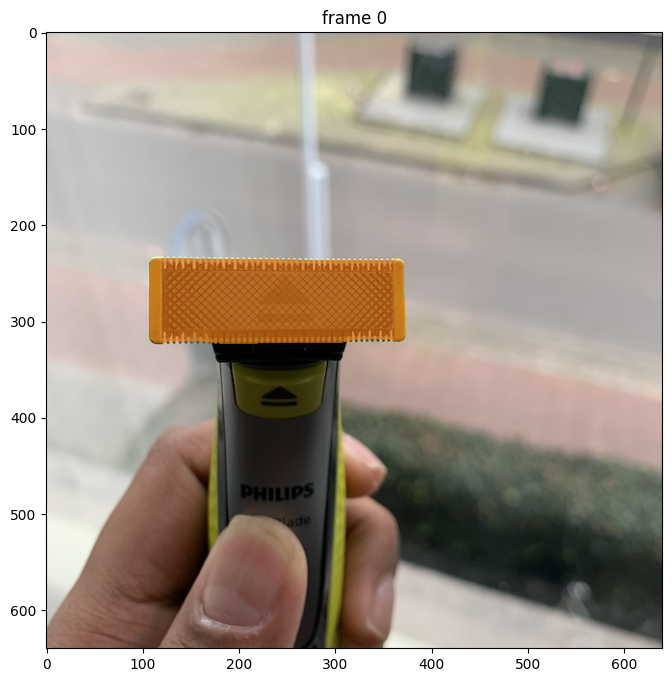

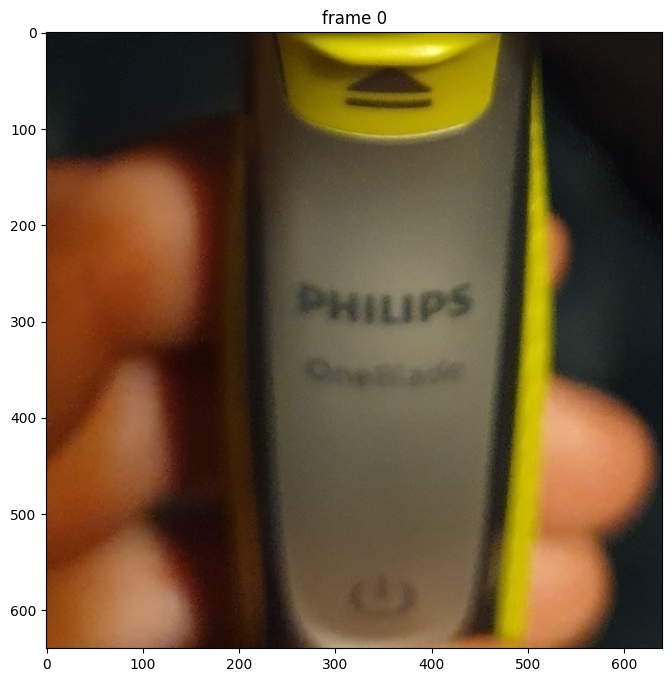

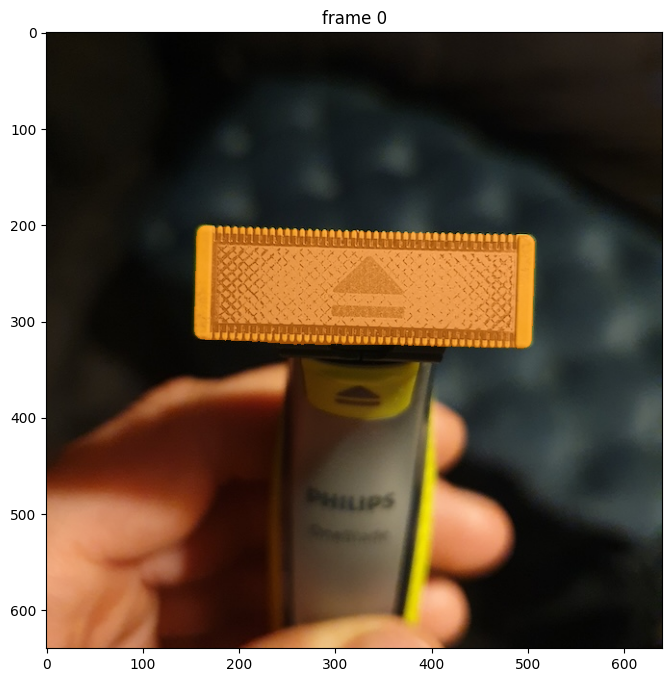

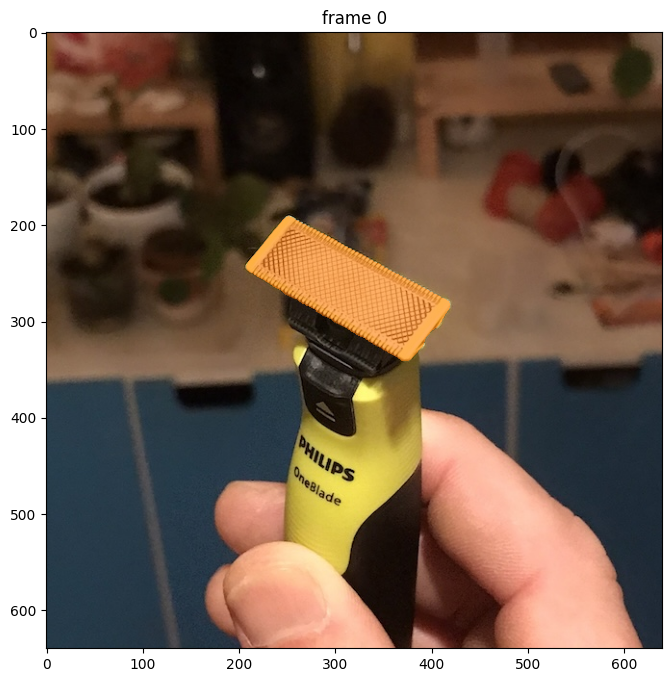

In [9]:
vis_gap = 30

for file in os.listdir("videos/prompts"):
    if not file.endswith(".jpg"):
        continue
    frame = Image.open(os.path.join("videos/prompts", file))

    # ret, frame = cap.read()
    # ann_frame_idx += 1
    # if not ret:
    #     break
    # width, height = frame.shape[:2][::-1]

    out_obj_ids, out_mask_logits = predictor.track(frame)

    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    display.clear_output(wait=True)
    plt.figure(figsize=(12, 8))
    plt.title(f"frame {ann_frame_idx}")
    plt.imshow(frame)
    show_mask(
        (out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0]
    )